## Activation Maximization on MNIST

https://github.com/raghakot/keras-vis/blob/master/examples/mnist/activation_maximization.ipynb

In [2]:
from __future__ import print_function

import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 138s 2ms/step - loss: 0.2348 - acc: 0.9277 - val_loss: 0.0523 - val_acc: 0.9830
Test loss: 0.05226928142679389
Test accuracy: 0.983


### Visualizing our Dense Layers



To visualize activation over final dense layer outputs, we need to **switch the softmax activation out for linear** since gradient of our output node will depend on all the other node activations. 

Doing this in keras is tricky, so they have provided **utils.apply_modifications** to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we don't do this at the end.

Lets start by visualizing an input that maximizes the output of node 0. This should look like a 0.


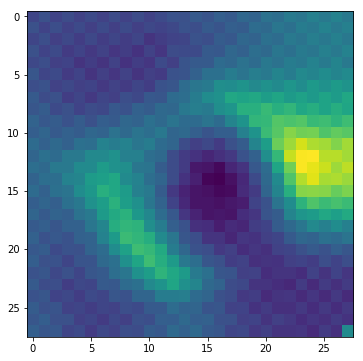

In [3]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])


While this sort of looks like a 0, it's not as clear as we hoped for. 

The reason is because because regularization parameters needs to be tuned depending on the problem. This can be improved by:

- The input to network is preprocessed to range (0, 1). We should specify input_range = (0., 1.) to constrain the input to this range.
- The regularization parameter default weights might be dominating activation maximization loss weight. One way to debug this is to use verbose=True and examine individual loss values.
 
Lets do these step by step and see if we can improve it.


## Specifying the Input Range

### First lets explore what the individual losses look like 

Iteration: 1, named_losses: [('ActivationMax Loss', -0.15108542),
 ('L-6.0 Norm Loss', 0.019832904),
 ('TV(2.0) Loss', 0.09261134)], overall loss: -0.03864116966724396
Iteration: 2, named_losses: [('ActivationMax Loss', -17.834694),
 ('L-6.0 Norm Loss', 0.17372927),
 ('TV(2.0) Loss', 500.69946)], overall loss: 483.03851318359375
Iteration: 3, named_losses: [('ActivationMax Loss', -66.595436),
 ('L-6.0 Norm Loss', 0.16593416),
 ('TV(2.0) Loss', 108.497185)], overall loss: 42.06768035888672
Iteration: 4, named_losses: [('ActivationMax Loss', -97.83832),
 ('L-6.0 Norm Loss', 0.17874704),
 ('TV(2.0) Loss', 124.46583)], overall loss: 26.806259155273438
Iteration: 5, named_losses: [('ActivationMax Loss', -132.24774),
 ('L-6.0 Norm Loss', 0.20311949),
 ('TV(2.0) Loss', 110.66194)], overall loss: -21.382675170898438
Iteration: 6, named_losses: [('ActivationMax Loss', -166.78386),
 ('L-6.0 Norm Loss', 0.22870126),
 ('TV(2.0) Loss', 117.853615)], overall loss: -48.70154571533203
Iteration: 7, na

Iteration: 66, named_losses: [('ActivationMax Loss', -489.50443),
 ('L-6.0 Norm Loss', 0.73187613),
 ('TV(2.0) Loss', 253.13095)], overall loss: -235.6416015625
Iteration: 67, named_losses: [('ActivationMax Loss', -488.19693),
 ('L-6.0 Norm Loss', 0.7287795),
 ('TV(2.0) Loss', 249.79301)], overall loss: -237.6751251220703
Iteration: 68, named_losses: [('ActivationMax Loss', -490.23514),
 ('L-6.0 Norm Loss', 0.7347146),
 ('TV(2.0) Loss', 254.678)], overall loss: -234.8224334716797
Iteration: 69, named_losses: [('ActivationMax Loss', -490.8689),
 ('L-6.0 Norm Loss', 0.7352741),
 ('TV(2.0) Loss', 252.4821)], overall loss: -237.6515350341797
Iteration: 70, named_losses: [('ActivationMax Loss', -491.31738),
 ('L-6.0 Norm Loss', 0.7379178),
 ('TV(2.0) Loss', 255.35866)], overall loss: -235.22080993652344
Iteration: 71, named_losses: [('ActivationMax Loss', -492.26324),
 ('L-6.0 Norm Loss', 0.73983985),
 ('TV(2.0) Loss', 253.76695)], overall loss: -237.75645446777344
Iteration: 72, named_loss

Iteration: 123, named_losses: [('ActivationMax Loss', -509.33304),
 ('L-6.0 Norm Loss', 0.8127906),
 ('TV(2.0) Loss', 259.2329)], overall loss: -249.28732299804688
Iteration: 124, named_losses: [('ActivationMax Loss', -510.93094),
 ('L-6.0 Norm Loss', 0.81595737),
 ('TV(2.0) Loss', 259.57916)], overall loss: -250.53582763671875
Iteration: 125, named_losses: [('ActivationMax Loss', -510.6399),
 ('L-6.0 Norm Loss', 0.81734556),
 ('TV(2.0) Loss', 259.85638)], overall loss: -249.96615600585938
Iteration: 126, named_losses: [('ActivationMax Loss', -512.3212),
 ('L-6.0 Norm Loss', 0.81980246),
 ('TV(2.0) Loss', 260.28024)], overall loss: -251.22119140625
Iteration: 127, named_losses: [('ActivationMax Loss', -511.93927),
 ('L-6.0 Norm Loss', 0.8219032),
 ('TV(2.0) Loss', 260.56152)], overall loss: -250.55584716796875
Iteration: 128, named_losses: [('ActivationMax Loss', -513.2652),
 ('L-6.0 Norm Loss', 0.8240419),
 ('TV(2.0) Loss', 260.64444)], overall loss: -251.79672241210938
Iteration: 129

Iteration: 175, named_losses: [('ActivationMax Loss', -538.9082),
 ('L-6.0 Norm Loss', 0.8997267),
 ('TV(2.0) Loss', 280.3142)], overall loss: -257.69427490234375
Iteration: 176, named_losses: [('ActivationMax Loss', -538.744),
 ('L-6.0 Norm Loss', 0.8997692),
 ('TV(2.0) Loss', 279.2578)], overall loss: -258.58642578125
Iteration: 177, named_losses: [('ActivationMax Loss', -539.65234),
 ('L-6.0 Norm Loss', 0.90226007),
 ('TV(2.0) Loss', 281.1297)], overall loss: -257.620361328125
Iteration: 178, named_losses: [('ActivationMax Loss', -539.95404),
 ('L-6.0 Norm Loss', 0.9019465),
 ('TV(2.0) Loss', 280.55872)], overall loss: -258.493408203125
Iteration: 179, named_losses: [('ActivationMax Loss', -539.80743),
 ('L-6.0 Norm Loss', 0.9041782),
 ('TV(2.0) Loss', 281.27756)], overall loss: -257.6257019042969
Iteration: 180, named_losses: [('ActivationMax Loss', -539.8412),
 ('L-6.0 Norm Loss', 0.9039606),
 ('TV(2.0) Loss', 280.18857)], overall loss: -258.7486877441406
Iteration: 181, named_los

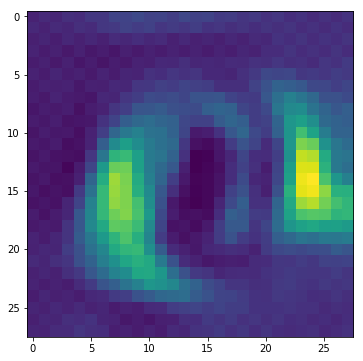

In [14]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
plt.imshow(img[..., 0])

### Now let's do it for all classes

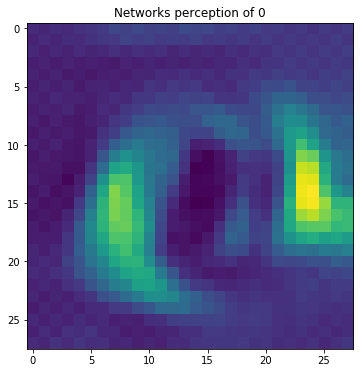

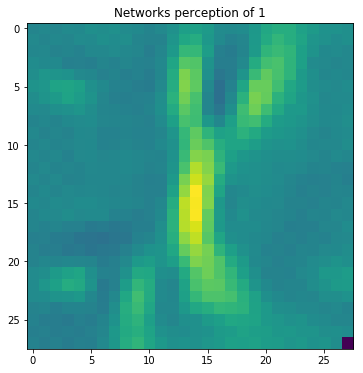

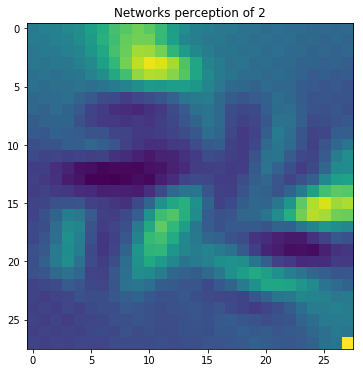

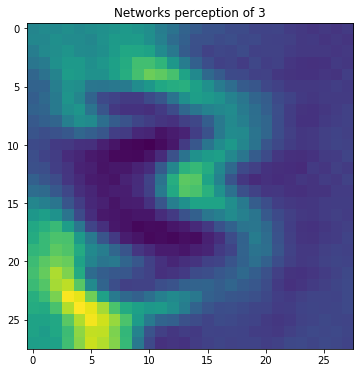

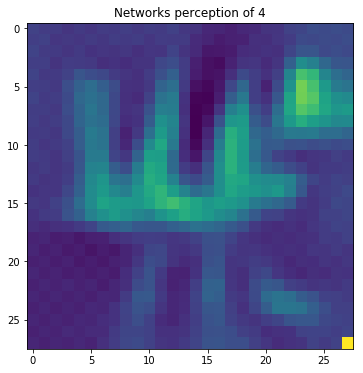

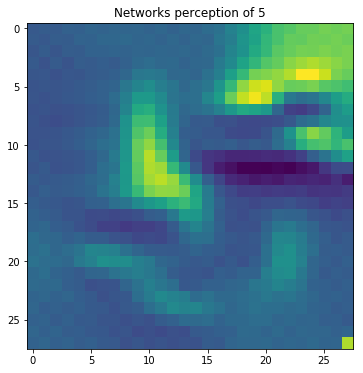

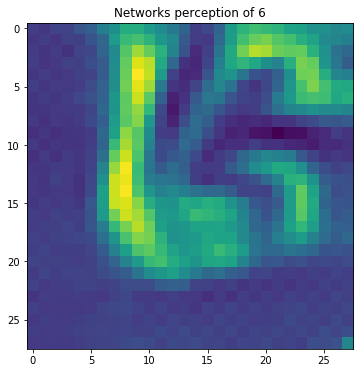

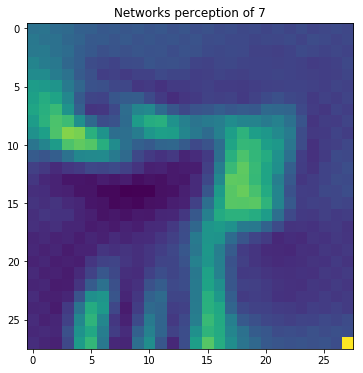

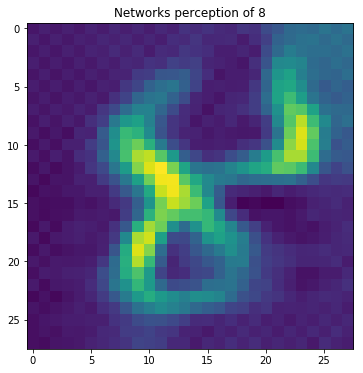

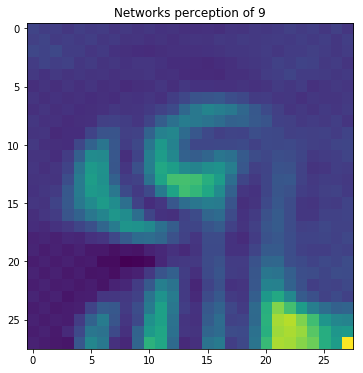

In [15]:
# Generating visualizations for all classes (0-9)
for output_idx in np.arange(10):
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])